In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, \
    ConfusionMatrixDisplay, precision_recall_curve
import pandas as pd
import json
from tqdm import tqdm
import optuna
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load data
def load_data(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return pd.DataFrame(data)


df = load_data('/content/drive/MyDrive/combinedData.json')
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['reviewText'].tolist(),
    df['class'].tolist(),
    test_size=0.2,
    random_state=42
)

In [ ]:
# Custom Dataset
class AmazonReviewDataset(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_length):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = str(self.reviews[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
# Evaluation function
def evaluate_model(model, dataloader, device):
    model.eval()
    val_preds, val_labels_actual = [], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)

            val_preds.extend(preds.cpu().tolist())
            val_labels_actual.extend(labels.cpu().tolist())

    accuracy = accuracy_score(val_labels_actual, val_preds)
    precision = precision_score(val_labels_actual, val_preds, average='binary')
    recall = recall_score(val_labels_actual, val_preds, average='binary')
    f1 = f1_score(val_labels_actual, val_preds, average='binary')

    return accuracy, precision, recall, f1, val_preds, val_labels_actual


In [ ]:
# Initialize the model and tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = GPT2Tokenizer.from_pretrained('openai-community/gpt2')
tokenizer.pad_token = tokenizer.eos_token
model = GPT2ForSequenceClassification.from_pretrained('openai-community/gpt2', num_labels=2)
model.config.pad_token_id = model.config.eos_token_id
model.to(device)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at openai-community/gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=2, bias=False)
)

In [ ]:
class_weights = torch.tensor([1.2, 0.8]).to(device)  # e.g., higher weight on non-spam to improve precision
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
# Initial hyperparameters
learning_rate = 1e-3
batch_size = 1
num_warmup_steps = 20

In [ ]:
# Create datasets and loaders
train_dataset = AmazonReviewDataset(train_texts, train_labels, tokenizer, max_length=128)
val_dataset = AmazonReviewDataset(val_texts, val_labels, tokenizer, max_length=128)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)


In [ ]:
# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps,
                                            num_training_steps=total_steps)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Track training loss for initial parameters
initial_train_losses = []
model.train()
for batch in train_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    optimizer.zero_grad()
    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    initial_train_losses.append(loss.item())
    loss.backward()
    optimizer.step()
    scheduler.step()

In [ ]:
# Evaluate before optimization
initial_metrics = evaluate_model(model, val_dataloader, device)
initial_accuracy, initial_precision, initial_recall, initial_f1, initial_preds, initial_labels = initial_metrics
print("Metrics before Optimization:")
print(f"Accuracy: {initial_accuracy:.4f}")
print(f"Precision: {initial_precision:.4f}")
print(f"Recall: {initial_recall:.4f}")
print(f"F1 Score: {initial_f1:.4f}")

Metrics before Optimization:
Accuracy: 0.8219
Precision: 0.8409
Recall: 0.8945
F1 Score: 0.8669


In [ ]:
# Visualization before optimization
def plot_metrics_comparison(before_values, after_values, labels, title):
    plt.figure(figsize=(10, 6))
    plt.bar(labels, before_values, alpha=0.6, label="Before Optimization")
    plt.bar(labels, after_values, alpha=0.6, label="After Optimization")
    plt.title(title)
    plt.legend()
    plt.show()

In [ ]:
# Hyperparameter optimization function
def objective(trial):
    # Hyperparameters to optimize
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-4)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])
    num_warmup_steps = trial.suggest_int('num_warmup_steps', 0, 100)

    # Update DataLoader and Model
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps,
                                                num_training_steps=total_steps)

    # Train loop for Optuna trial
    model.train()
    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

    # Evaluate and return F1 score
    _, _, _, f1, _, _ = evaluate_model(model, val_dataloader, device)
    return f1

In [ ]:
# Run optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2024-10-30 20:33:35,692] A new study created in memory with name: no-name-1c21ecd7-3bde-472f-ab51-73ac39ee81a4
<ipython-input-174-643fbf0f77b8>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-4)
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
[I 2024-10-30 20:41:49,889] Trial 0 finished with value: 0.8665105386416861 and parameters: {'learning_rate': 1.4859016907656505e-05, 'batch_size': 8, 'num_warmup_steps': 37}. Best is trial 0 with value: 0.8665105386416861.
<ipython-input-174-643fbf0f77b8>:4: Futu

In [ ]:
# Output best parameters
print("Best Hyperparameters:", study.best_params)

Best Hyperparameters: {'learning_rate': 6.738871529696803e-05, 'batch_size': 16, 'num_warmup_steps': 0}


In [ ]:
# Re-train with optimized hyperparameters
best_params = study.best_params
learning_rate = best_params['learning_rate']
batch_size = best_params['batch_size']
num_warmup_steps = best_params['num_warmup_steps']

In [ ]:
# Re-initialize model, optimizer, and scheduler with optimized hyperparameters
model = GPT2ForSequenceClassification.from_pretrained('openai-community/gpt2', num_labels=2)
model.config.pad_token_id = model.config.eos_token_id
model.to(device)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
optimizer = AdamW(model.parameters(), lr=learning_rate)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps,
                                            num_training_steps=total_steps)


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at openai-community/gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:

# Track training loss for optimized parameters
optimized_train_losses = []
model.train()
for batch in train_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    optimizer.zero_grad()
    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    optimized_train_losses.append(loss.item())
    loss.backward()
    optimizer.step()
    scheduler.step()

In [ ]:
# Evaluate after optimization
optimized_metrics = evaluate_model(model, val_dataloader, device)
optimized_accuracy, optimized_precision, optimized_recall, optimized_f1, optimized_preds, optimized_labels = optimized_metrics
print("\nMetrics after Optimization:")
print(f"Accuracy: {optimized_accuracy:.4f}")
print(f"Precision: {optimized_precision:.4f}")
print(f"Recall: {optimized_recall:.4f}")
print(f"F1 Score: {optimized_f1:.4f}")


Metrics after Optimization:
Accuracy: 0.8936
Precision: 0.9043
Recall: 0.9348
F1 Score: 0.9193


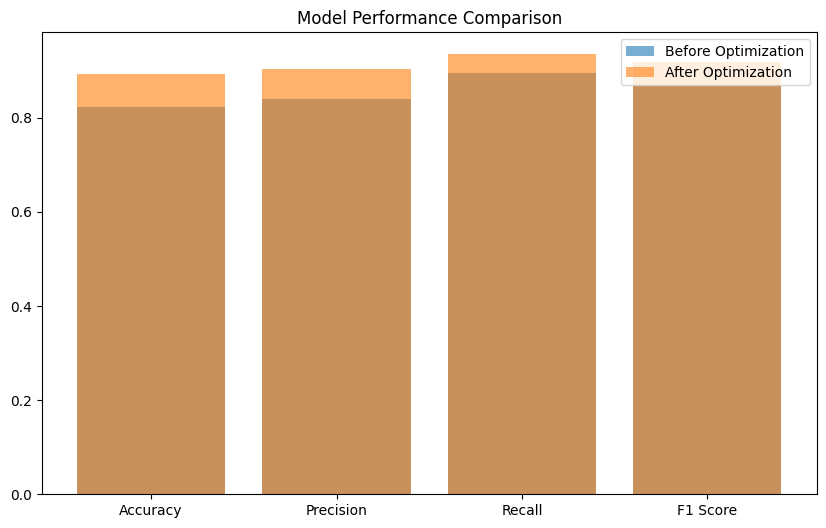

In [ ]:
# Visualization of metrics comparison
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
initial_values = [initial_accuracy, initial_precision, initial_recall, initial_f1]
optimized_values = [optimized_accuracy, optimized_precision, optimized_recall, optimized_f1]
plot_metrics_comparison(initial_values, optimized_values, labels, "Model Performance Comparison")


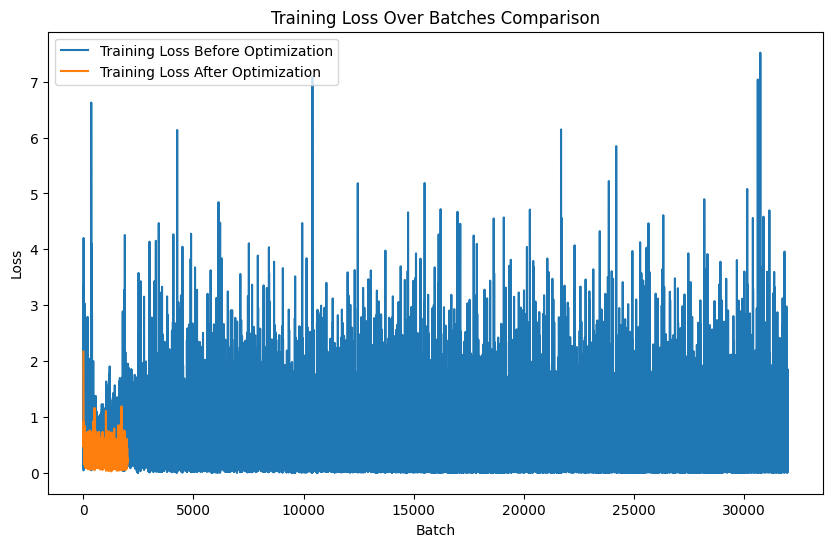

In [ ]:
# Training Loss Comparison
plt.figure(figsize=(10, 6))
plt.plot(initial_train_losses, label="Training Loss Before Optimization")
plt.plot(optimized_train_losses, label="Training Loss After Optimization")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Training Loss Over Batches Comparison")
plt.legend()
plt.show()

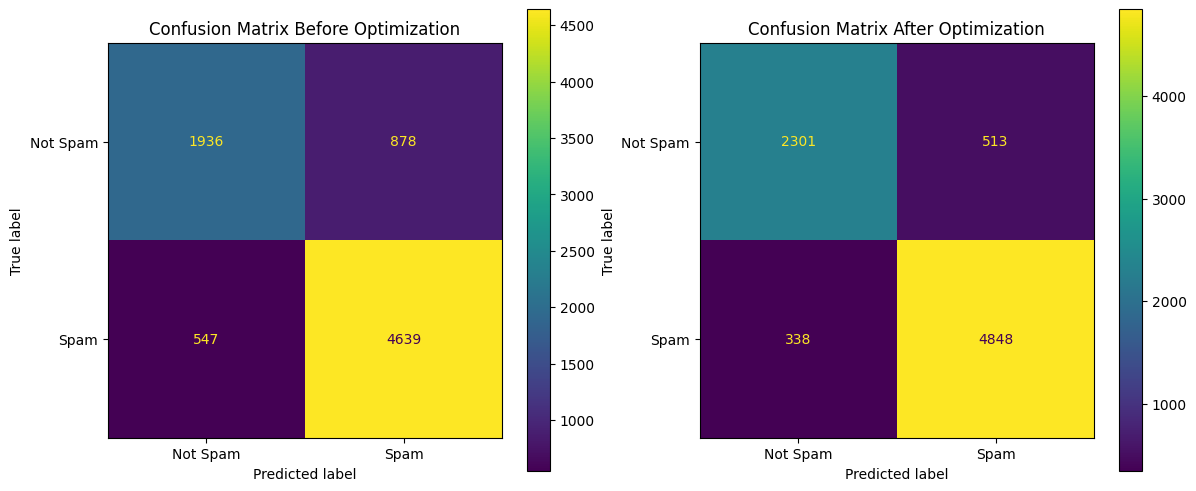

In [ ]:
# Confusion Matrix Comparison
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ConfusionMatrixDisplay.from_predictions(initial_labels, initial_preds, ax=ax[0], display_labels=["Not Spam", "Spam"])
ax[0].set_title("Confusion Matrix Before Optimization")
ConfusionMatrixDisplay.from_predictions(optimized_labels, optimized_preds, ax=ax[1],
                                        display_labels=["Not Spam", "Spam"])
ax[1].set_title("Confusion Matrix After Optimization")
plt.show()

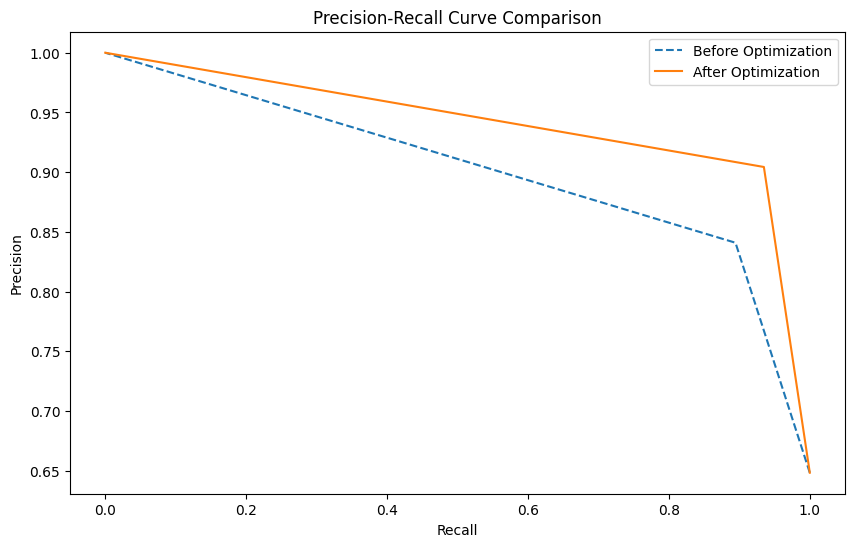

In [ ]:
# Precision-Recall Curve Comparison
initial_precision_vals, initial_recall_vals, _ = precision_recall_curve(initial_labels, initial_preds)
optimized_precision_vals, optimized_recall_vals, _ = precision_recall_curve(optimized_labels, optimized_preds)
plt.figure(figsize=(10, 6))
plt.plot(initial_recall_vals, initial_precision_vals, label="Before Optimization", linestyle='--')
plt.plot(optimized_recall_vals, optimized_precision_vals, label="After Optimization")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")
plt.legend()
plt.show()

In [ ]:
# Save the model

torch.save(model.state_dict(), 'gpt2_spam_detector_optimized.pth')

In [3]:
# Prediction Function
def predict_spam(review, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        max_length=max_length,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        prediction = torch.argmax(outputs.logits, dim=1)

    return "Spam" if prediction.item() == 1 else "Not Spam"

In [8]:

from transformers import GPT2Tokenizer, GPT2ForSequenceClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('openai-community/gpt2')
tokenizer.pad_token = tokenizer.eos_token
model = GPT2ForSequenceClassification.from_pretrained('openai-community/gpt2', num_labels=2)
model.load_state_dict(torch.load('gpt2_spam_detector.pth'))
model.to(device)

# Use predict_spam to classify a new review
new_review = "This product is amazing! I can't believe how well it works. Highly recommended!"
result = predict_spam(new_review, model, tokenizer, device)
print(f"Review: {new_review}")
print(f"Prediction: {result}")

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at openai-community/gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/br/w3pk101n4kx4dfh2d3pc8bnc0000gn/T/ipykernel_33853/1305888353.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serializatio

Review: This product is amazing! I can't believe how well it works. Highly recommended!
Prediction: Spam
